In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [20]:
class NCaltech101ImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((101,))
        label_temp[label] = 1
        return torch.tensor(image), torch.tensor(label_temp)

In [21]:
training_data = NCaltech101ImageDataset("./Datasety/Ncaltech101")

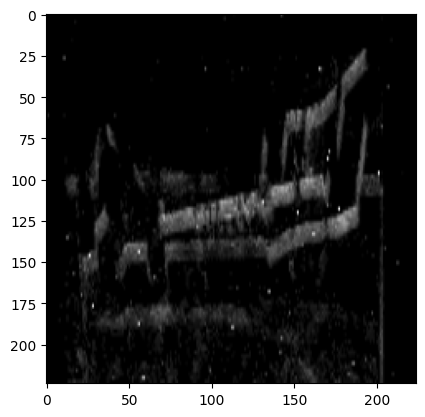

tensor(0.8586)


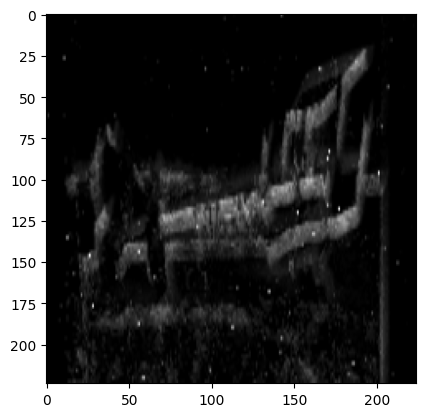

tensor(0.8586)


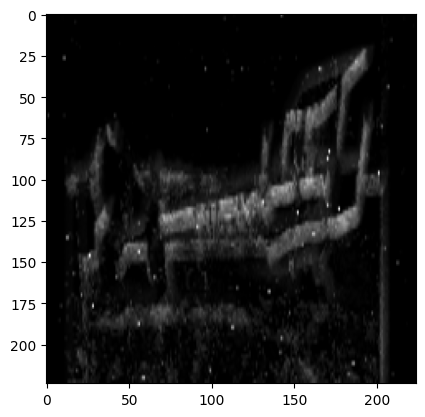

tensor(0.8587)


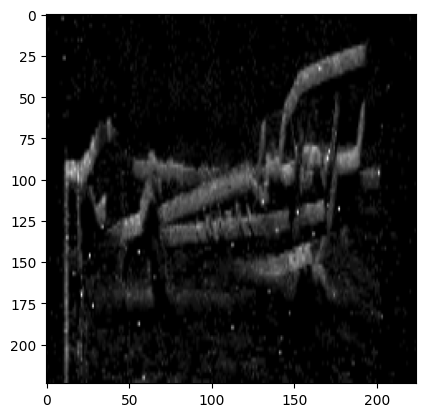

tensor(0.8586)


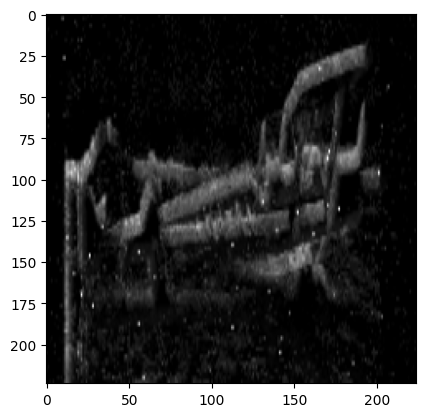

tensor(0.8587)


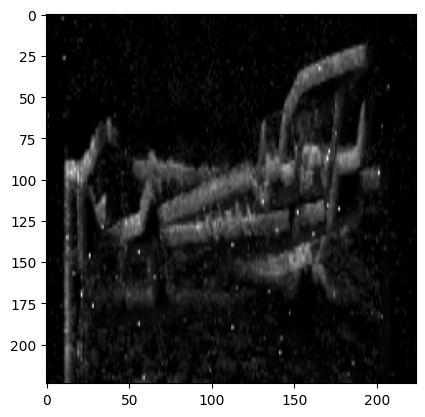

tensor(0.8588)


In [22]:
pic, label = training_data[100]

noBins = 3
for i in range(2*noBins):
    pic2 = pic[i,...]
    plt.gray()
    plt.imshow(pic2)
    plt.show()
    print(torch.max(pic2))

In [23]:
train_dataset, test_dataset = torch.utils.data.random_split(training_data, [0.8, 0.2])

In [24]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST__FC2.pt")

                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))

In [26]:
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 6, num_classes=101).to("cuda")

In [27]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=10)

100%|██████████| 109/109 [00:48<00:00,  2.25it/s]


Epoch [1/10], Step [109/109], Loss: 4.4983, Accuracy: 0.0560
Accuracy of the network: 8.788052843193567 Loss: 4.263938971928188%


100%|██████████| 109/109 [00:49<00:00,  2.20it/s]


Epoch [2/10], Step [109/109], Loss: 4.2359, Accuracy: 0.1036
Accuracy of the network: 11.200459506031017 Loss: 4.231876083782741%


100%|██████████| 109/109 [00:49<00:00,  2.19it/s]


Epoch [3/10], Step [109/109], Loss: 4.2161, Accuracy: 0.1072
Accuracy of the network: 9.190120620333142 Loss: 4.274690542902265%


100%|██████████| 109/109 [00:48<00:00,  2.26it/s]


Epoch [4/10], Step [109/109], Loss: 4.2106, Accuracy: 0.1046
Accuracy of the network: 11.143021252153934 Loss: 4.225770626749311%


100%|██████████| 109/109 [00:46<00:00,  2.36it/s]


Epoch [5/10], Step [109/109], Loss: 4.1843, Accuracy: 0.1137
Accuracy of the network: 11.774842044801838 Loss: 4.148184359073639%


100%|██████████| 109/109 [00:44<00:00,  2.43it/s]


Epoch [6/10], Step [109/109], Loss: 4.1669, Accuracy: 0.1135
Accuracy of the network: 12.176909821941413 Loss: 4.148388590131487%


100%|██████████| 109/109 [00:44<00:00,  2.45it/s]


Epoch [7/10], Step [109/109], Loss: 4.1739, Accuracy: 0.1155
Accuracy of the network: 12.062033314187248 Loss: 4.166268323149%


100%|██████████| 109/109 [00:46<00:00,  2.37it/s]


Epoch [8/10], Step [109/109], Loss: 4.1325, Accuracy: 0.1243
Accuracy of the network: 13.15336013785181 Loss: 4.106487223080227%


100%|██████████| 109/109 [00:44<00:00,  2.48it/s]


Epoch [9/10], Step [109/109], Loss: 4.0989, Accuracy: 0.1277
Accuracy of the network: 13.44055140723722 Loss: 4.093897879123688%


100%|██████████| 109/109 [00:45<00:00,  2.40it/s]


Epoch [10/10], Step [109/109], Loss: 4.0838, Accuracy: 0.1280
Accuracy of the network: 13.785180930499713 Loss: 4.0465461782046726%


In [29]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,learning_rate=1e-4)

100%|██████████| 109/109 [00:44<00:00,  2.45it/s]


Epoch [1/100], Step [109/109], Loss: 4.1391, Accuracy: 0.1244
Accuracy of the network: 11.602527283170591 Loss: 4.1304929086140225%


100%|██████████| 109/109 [00:44<00:00,  2.44it/s]


Epoch [2/100], Step [109/109], Loss: 4.1041, Accuracy: 0.1241
Accuracy of the network: 12.521539345203905 Loss: 4.081217510359628%


100%|██████████| 109/109 [00:45<00:00,  2.38it/s]


Epoch [3/100], Step [109/109], Loss: 4.0656, Accuracy: 0.1270
Accuracy of the network: 13.268236645605974 Loss: 4.065919748374394%


100%|██████████| 109/109 [00:46<00:00,  2.36it/s]


Epoch [4/100], Step [109/109], Loss: 4.0499, Accuracy: 0.1287
Accuracy of the network: 12.981045376220562 Loss: 4.04776747737612%


100%|██████████| 109/109 [00:43<00:00,  2.48it/s]


Epoch [5/100], Step [109/109], Loss: 4.0206, Accuracy: 0.1306
Accuracy of the network: 13.497989661114302 Loss: 3.9973532387188504%


100%|██████████| 109/109 [00:42<00:00,  2.58it/s]


Epoch [6/100], Step [109/109], Loss: 3.9626, Accuracy: 0.1338
Accuracy of the network: 14.01493394600804 Loss: 3.9479936191013882%


100%|██████████| 109/109 [00:44<00:00,  2.44it/s]


Epoch [7/100], Step [109/109], Loss: 3.9192, Accuracy: 0.1369
Accuracy of the network: 13.727742676622631 Loss: 3.9016613279070174%


100%|██████████| 109/109 [00:45<00:00,  2.41it/s]


Epoch [8/100], Step [109/109], Loss: 3.8811, Accuracy: 0.1348
Accuracy of the network: 13.383113153360139 Loss: 3.870394306523459%


100%|██████████| 109/109 [00:44<00:00,  2.42it/s]


Epoch [9/100], Step [109/109], Loss: 3.8541, Accuracy: 0.1335
Accuracy of the network: 13.44055140723722 Loss: 3.8400132826396396%


100%|██████████| 109/109 [00:44<00:00,  2.43it/s]


Epoch [10/100], Step [109/109], Loss: 3.8170, Accuracy: 0.1376
Accuracy of the network: 13.727742676622631 Loss: 3.817773316587721%


100%|██████████| 109/109 [00:44<00:00,  2.42it/s]


Epoch [11/100], Step [109/109], Loss: 3.8010, Accuracy: 0.1371
Accuracy of the network: 13.612866168868466 Loss: 3.8180809872491017%


100%|██████████| 109/109 [00:44<00:00,  2.44it/s]


Epoch [12/100], Step [109/109], Loss: 3.7735, Accuracy: 0.1365
Accuracy of the network: 14.01493394600804 Loss: 3.791954679148538%


100%|██████████| 109/109 [00:44<00:00,  2.45it/s]


Epoch [13/100], Step [109/109], Loss: 3.7441, Accuracy: 0.1395
Accuracy of the network: 14.129810453762206 Loss: 3.7923928669520786%


100%|██████████| 109/109 [00:44<00:00,  2.44it/s]


Epoch [14/100], Step [109/109], Loss: 3.7155, Accuracy: 0.1409
Accuracy of the network: 14.01493394600804 Loss: 3.7190112386431013%


100%|██████████| 109/109 [00:42<00:00,  2.55it/s]


Epoch [15/100], Step [109/109], Loss: 3.6814, Accuracy: 0.1419
Accuracy of the network: 14.187248707639288 Loss: 3.727204288755144%


100%|██████████| 109/109 [00:44<00:00,  2.43it/s]


Epoch [16/100], Step [109/109], Loss: 3.6619, Accuracy: 0.1389
Accuracy of the network: 14.129810453762206 Loss: 3.660443024975913%


100%|██████████| 109/109 [00:44<00:00,  2.44it/s]


Epoch [17/100], Step [109/109], Loss: 3.6368, Accuracy: 0.1425
Accuracy of the network: 13.957495692130959 Loss: 3.6621011921337674%


100%|██████████| 109/109 [00:46<00:00,  2.34it/s]


Epoch [18/100], Step [109/109], Loss: 3.6191, Accuracy: 0.1405
Accuracy of the network: 13.957495692130959 Loss: 3.7176833919116428%


100%|██████████| 109/109 [00:45<00:00,  2.38it/s]


Epoch [19/100], Step [109/109], Loss: 3.6015, Accuracy: 0.1405
Accuracy of the network: 13.727742676622631 Loss: 3.6268904975482394%


100%|██████████| 109/109 [00:44<00:00,  2.46it/s]


Epoch [20/100], Step [109/109], Loss: 3.5835, Accuracy: 0.1406
Accuracy of the network: 13.727742676622631 Loss: 3.6192404883248463%


100%|██████████| 109/109 [00:45<00:00,  2.40it/s]


Epoch [21/100], Step [109/109], Loss: 3.5670, Accuracy: 0.1405
Accuracy of the network: 14.01493394600804 Loss: 3.590032253946577%


100%|██████████| 109/109 [00:47<00:00,  2.29it/s]


Epoch [22/100], Step [109/109], Loss: 3.5538, Accuracy: 0.1406
Accuracy of the network: 14.302125215393453 Loss: 3.593814023903438%


100%|██████████| 109/109 [00:49<00:00,  2.22it/s]


Epoch [23/100], Step [109/109], Loss: 3.5279, Accuracy: 0.1424
Accuracy of the network: 13.268236645605974 Loss: 3.6011273860931396%


100%|██████████| 109/109 [00:49<00:00,  2.20it/s]


Epoch [24/100], Step [109/109], Loss: 3.5128, Accuracy: 0.1414
Accuracy of the network: 13.842619184376796 Loss: 3.560747061456953%


100%|██████████| 109/109 [00:49<00:00,  2.21it/s]


Epoch [25/100], Step [109/109], Loss: 3.5122, Accuracy: 0.1418
Accuracy of the network: 14.417001723147616 Loss: 3.567347833088466%


100%|██████████| 109/109 [00:48<00:00,  2.23it/s]


Epoch [26/100], Step [109/109], Loss: 3.4860, Accuracy: 0.1460
Accuracy of the network: 15.967834577828834 Loss: 3.5658258540289745%


100%|██████████| 109/109 [00:48<00:00,  2.23it/s]


Epoch [27/100], Step [109/109], Loss: 3.4727, Accuracy: 0.1566
Accuracy of the network: 14.072372199885123 Loss: 3.560846669333322%


100%|██████████| 109/109 [00:49<00:00,  2.22it/s]


Epoch [28/100], Step [109/109], Loss: 3.4653, Accuracy: 0.1461
Accuracy of the network: 14.589316484778863 Loss: 3.5214477692331587%


100%|██████████| 109/109 [00:49<00:00,  2.21it/s]


Epoch [29/100], Step [109/109], Loss: 3.4454, Accuracy: 0.2011
Accuracy of the network: 30.61458931648478 Loss: 3.5097516008785794%


100%|██████████| 109/109 [00:48<00:00,  2.23it/s]


Epoch [30/100], Step [109/109], Loss: 3.4222, Accuracy: 0.3210
Accuracy of the network: 29.121194715680645 Loss: 3.4972034181867326%


100%|██████████| 109/109 [00:48<00:00,  2.23it/s]


Epoch [31/100], Step [109/109], Loss: 3.4069, Accuracy: 0.3219
Accuracy of the network: 31.303848363009763 Loss: 3.500832898276193%


100%|██████████| 109/109 [00:49<00:00,  2.22it/s]


Epoch [32/100], Step [109/109], Loss: 3.3961, Accuracy: 0.3285
Accuracy of the network: 31.418724870763928 Loss: 3.4720218011311124%


100%|██████████| 109/109 [00:42<00:00,  2.57it/s]


Epoch [33/100], Step [109/109], Loss: 3.3882, Accuracy: 0.3259
Accuracy of the network: 31.648477886272257 Loss: 3.4663612927709306%


100%|██████████| 109/109 [00:41<00:00,  2.61it/s]


Epoch [34/100], Step [109/109], Loss: 3.3775, Accuracy: 0.3253
Accuracy of the network: 31.820792647903502 Loss: 3.4787321516445706%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [35/100], Step [109/109], Loss: 3.3721, Accuracy: 0.3239
Accuracy of the network: 31.70591614014934 Loss: 3.463940049920763%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [36/100], Step [109/109], Loss: 3.3594, Accuracy: 0.3332
Accuracy of the network: 32.39517518667432 Loss: 3.4379798344203403%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [37/100], Step [109/109], Loss: 3.3557, Accuracy: 0.3331
Accuracy of the network: 32.165422171166 Loss: 3.4481889520372664%


100%|██████████| 109/109 [00:41<00:00,  2.65it/s]


Epoch [38/100], Step [109/109], Loss: 3.3417, Accuracy: 0.3345
Accuracy of the network: 33.19931074095347 Loss: 3.4633115104266574%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [39/100], Step [109/109], Loss: 3.3297, Accuracy: 0.3375
Accuracy of the network: 34.00344629523263 Loss: 3.4463289890970503%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [40/100], Step [109/109], Loss: 3.3228, Accuracy: 0.3377
Accuracy of the network: 32.56748994830557 Loss: 3.440838771206992%


100%|██████████| 109/109 [00:41<00:00,  2.65it/s]


Epoch [41/100], Step [109/109], Loss: 3.3210, Accuracy: 0.3411
Accuracy of the network: 33.83113153360138 Loss: 3.428311058453151%


100%|██████████| 109/109 [00:41<00:00,  2.65it/s]


Epoch [42/100], Step [109/109], Loss: 3.3051, Accuracy: 0.3476
Accuracy of the network: 33.37162550258472 Loss: 3.424402219908578%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [43/100], Step [109/109], Loss: 3.3021, Accuracy: 0.3454
Accuracy of the network: 32.7972429638139 Loss: 3.420168263571603%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [44/100], Step [109/109], Loss: 3.2975, Accuracy: 0.3466
Accuracy of the network: 33.71625502584721 Loss: 3.417299313204629%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [45/100], Step [109/109], Loss: 3.2989, Accuracy: 0.3441
Accuracy of the network: 32.96955772544515 Loss: 3.42766626392092%


100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


Epoch [46/100], Step [109/109], Loss: 3.2856, Accuracy: 0.3480
Accuracy of the network: 33.02699597932223 Loss: 3.4458193693842207%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [47/100], Step [109/109], Loss: 3.2859, Accuracy: 0.3467
Accuracy of the network: 34.11832280298679 Loss: 3.3968043071883067%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [48/100], Step [109/109], Loss: 3.2673, Accuracy: 0.3540
Accuracy of the network: 34.34807581849512 Loss: 3.4394047686031888%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [49/100], Step [109/109], Loss: 3.2756, Accuracy: 0.3558
Accuracy of the network: 33.48650201033889 Loss: 3.4024558322770253%


100%|██████████| 109/109 [00:41<00:00,  2.65it/s]


Epoch [50/100], Step [109/109], Loss: 3.2590, Accuracy: 0.3601
Accuracy of the network: 33.19931074095347 Loss: 3.403206833771297%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [51/100], Step [109/109], Loss: 3.2645, Accuracy: 0.3512
Accuracy of the network: 32.7972429638139 Loss: 3.4085679735456194%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [52/100], Step [109/109], Loss: 3.2486, Accuracy: 0.3579
Accuracy of the network: 34.00344629523263 Loss: 3.3953931416784013%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [53/100], Step [109/109], Loss: 3.2433, Accuracy: 0.3559
Accuracy of the network: 34.34807581849512 Loss: 3.369214262281145%


100%|██████████| 109/109 [00:39<00:00,  2.73it/s]


Epoch [54/100], Step [109/109], Loss: 3.2427, Accuracy: 0.3589
Accuracy of the network: 33.83113153360138 Loss: 3.393500804901123%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [55/100], Step [109/109], Loss: 3.2344, Accuracy: 0.3724
Accuracy of the network: 34.75014359563469 Loss: 3.41592937707901%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [56/100], Step [109/109], Loss: 3.2407, Accuracy: 0.3657
Accuracy of the network: 32.33773693279724 Loss: 3.4064060109002248%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [57/100], Step [109/109], Loss: 3.2219, Accuracy: 0.3776
Accuracy of the network: 34.97989661114302 Loss: 3.4197468757629395%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [58/100], Step [109/109], Loss: 3.2185, Accuracy: 0.3714
Accuracy of the network: 34.34807581849512 Loss: 3.3833846875599454%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [59/100], Step [109/109], Loss: 3.2216, Accuracy: 0.3789
Accuracy of the network: 36.128661688684666 Loss: 3.396904340812138%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [60/100], Step [109/109], Loss: 3.2108, Accuracy: 0.3865
Accuracy of the network: 34.75014359563469 Loss: 3.3787918516567776%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [61/100], Step [109/109], Loss: 3.1998, Accuracy: 0.3878
Accuracy of the network: 35.15221137277427 Loss: 3.408080884388515%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [62/100], Step [109/109], Loss: 3.1938, Accuracy: 0.3957
Accuracy of the network: 35.32452613440552 Loss: 3.371173518044608%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [63/100], Step [109/109], Loss: 3.1863, Accuracy: 0.3971
Accuracy of the network: 36.81792073520965 Loss: 3.3708009890147617%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [64/100], Step [109/109], Loss: 3.1986, Accuracy: 0.3912
Accuracy of the network: 36.58816771970132 Loss: 3.371112355164119%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [65/100], Step [109/109], Loss: 3.1827, Accuracy: 0.4018
Accuracy of the network: 37.10511200459506 Loss: 3.395769323621477%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [66/100], Step [109/109], Loss: 3.1818, Accuracy: 0.4126
Accuracy of the network: 37.392303273980474 Loss: 3.3586071729660034%


100%|██████████| 109/109 [00:38<00:00,  2.81it/s]


Epoch [67/100], Step [109/109], Loss: 3.1799, Accuracy: 0.3994
Accuracy of the network: 36.30097645031591 Loss: 3.3746906178338185%


100%|██████████| 109/109 [00:40<00:00,  2.68it/s]


Epoch [68/100], Step [109/109], Loss: 3.1834, Accuracy: 0.3971
Accuracy of the network: 37.851809304997126 Loss: 3.3823842150824412%


100%|██████████| 109/109 [00:41<00:00,  2.64it/s]


Epoch [69/100], Step [109/109], Loss: 3.1751, Accuracy: 0.4080
Accuracy of the network: 36.703044227455486 Loss: 3.360699568475996%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [70/100], Step [109/109], Loss: 3.1632, Accuracy: 0.4027
Accuracy of the network: 35.78403216542217 Loss: 3.3721738287380765%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [71/100], Step [109/109], Loss: 3.1666, Accuracy: 0.4110
Accuracy of the network: 38.94313612866169 Loss: 3.373451888561249%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [72/100], Step [109/109], Loss: 3.1679, Accuracy: 0.4034
Accuracy of the network: 38.311315336013784 Loss: 3.369300518717085%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [73/100], Step [109/109], Loss: 3.1646, Accuracy: 0.4069
Accuracy of the network: 35.3819643882826 Loss: 3.3829568454197476%


100%|██████████| 109/109 [00:40<00:00,  2.68it/s]


Epoch [74/100], Step [109/109], Loss: 3.1567, Accuracy: 0.4120
Accuracy of the network: 38.94313612866169 Loss: 3.3429975169045583%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [75/100], Step [109/109], Loss: 3.1480, Accuracy: 0.4234
Accuracy of the network: 38.19643882825962 Loss: 3.3658888936042786%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [76/100], Step [109/109], Loss: 3.1537, Accuracy: 0.4129
Accuracy of the network: 37.622056289488796 Loss: 3.361204590116228%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [77/100], Step [109/109], Loss: 3.1523, Accuracy: 0.4193
Accuracy of the network: 39.115450890292934 Loss: 3.362024588244302%


100%|██████████| 109/109 [00:40<00:00,  2.66it/s]


Epoch [78/100], Step [109/109], Loss: 3.1443, Accuracy: 0.4247
Accuracy of the network: 35.554279149913846 Loss: 3.3553237915039062%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [79/100], Step [109/109], Loss: 3.1470, Accuracy: 0.4205
Accuracy of the network: 39.57495692130959 Loss: 3.3660436187471663%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [80/100], Step [109/109], Loss: 3.1465, Accuracy: 0.4188
Accuracy of the network: 37.851809304997126 Loss: 3.3853811110769%


100%|██████████| 109/109 [00:40<00:00,  2.67it/s]


Epoch [81/100], Step [109/109], Loss: 3.1438, Accuracy: 0.4063
Accuracy of the network: 36.81792073520965 Loss: 3.380372566836221%


100%|██████████| 109/109 [00:41<00:00,  2.65it/s]


Epoch [82/100], Step [109/109], Loss: 3.1366, Accuracy: 0.4212
Accuracy of the network: 37.622056289488796 Loss: 3.397811089243208%


100%|██████████| 109/109 [00:41<00:00,  2.66it/s]


Epoch [83/100], Step [109/109], Loss: 3.1373, Accuracy: 0.4224
Accuracy of the network: 36.53072946582424 Loss: 3.37123555796487%


100%|██████████| 109/109 [00:39<00:00,  2.74it/s]


Epoch [84/100], Step [109/109], Loss: 3.1325, Accuracy: 0.4274
Accuracy of the network: 38.541068351522114 Loss: 3.3854674015726363%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [85/100], Step [109/109], Loss: 3.1298, Accuracy: 0.4235
Accuracy of the network: 37.334865020103386 Loss: 3.386129992348807%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [86/100], Step [109/109], Loss: 3.1333, Accuracy: 0.4268
Accuracy of the network: 36.24353819643883 Loss: 3.37128415278026%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [87/100], Step [109/109], Loss: 3.1330, Accuracy: 0.4282
Accuracy of the network: 37.564618035611716 Loss: 3.3779730200767517%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [88/100], Step [109/109], Loss: 3.1387, Accuracy: 0.4178
Accuracy of the network: 37.047673750717976 Loss: 3.3617317421095714%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [89/100], Step [109/109], Loss: 3.1191, Accuracy: 0.4361
Accuracy of the network: 39.63239517518667 Loss: 3.3597726140703474%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [90/100], Step [109/109], Loss: 3.1191, Accuracy: 0.4287
Accuracy of the network: 37.219988512349225 Loss: 3.3480978437832425%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [91/100], Step [109/109], Loss: 3.1143, Accuracy: 0.4407
Accuracy of the network: 39.63239517518667 Loss: 3.3503781301634654%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [92/100], Step [109/109], Loss: 3.1191, Accuracy: 0.4354
Accuracy of the network: 37.966685812751294 Loss: 3.3708458287375316%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [93/100], Step [109/109], Loss: 3.1167, Accuracy: 0.4402
Accuracy of the network: 39.172889144170014 Loss: 3.349216137613569%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [94/100], Step [109/109], Loss: 3.1117, Accuracy: 0.4476
Accuracy of the network: 38.541068351522114 Loss: 3.351678967475891%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [95/100], Step [109/109], Loss: 3.1138, Accuracy: 0.4410
Accuracy of the network: 37.564618035611716 Loss: 3.3545915569577898%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [96/100], Step [109/109], Loss: 3.1163, Accuracy: 0.4358
Accuracy of the network: 39.46008041355543 Loss: 3.380480536392757%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [97/100], Step [109/109], Loss: 3.1140, Accuracy: 0.4459
Accuracy of the network: 37.622056289488796 Loss: 3.3603423493249074%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [98/100], Step [109/109], Loss: 3.1064, Accuracy: 0.4374
Accuracy of the network: 37.334865020103386 Loss: 3.356567527566637%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [99/100], Step [109/109], Loss: 3.1052, Accuracy: 0.4425
Accuracy of the network: 39.862148190695 Loss: 3.3539264798164368%


100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [100/100], Step [109/109], Loss: 3.0981, Accuracy: 0.4480
Accuracy of the network: 38.139000574382536 Loss: 3.3648797188486372%


In [30]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,learning_rate=3e-5)

100%|██████████| 109/109 [00:38<00:00,  2.82it/s]


Epoch [1/100], Step [109/109], Loss: 3.0876, Accuracy: 0.4620
Accuracy of the network: 42.84893739230328 Loss: 3.345962413719722%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [2/100], Step [109/109], Loss: 3.0127, Accuracy: 0.5357
Accuracy of the network: 42.73406088454911 Loss: 3.338705905846187%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [3/100], Step [109/109], Loss: 2.9934, Accuracy: 0.5451
Accuracy of the network: 44.227455485353246 Loss: 3.3396931971822466%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [4/100], Step [109/109], Loss: 2.9781, Accuracy: 0.5742
Accuracy of the network: 43.882825962090756 Loss: 3.3364865013531277%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [5/100], Step [109/109], Loss: 2.9720, Accuracy: 0.5742
Accuracy of the network: 42.61918437679495 Loss: 3.347241623061044%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [6/100], Step [109/109], Loss: 2.9683, Accuracy: 0.5697
Accuracy of the network: 43.94026421596784 Loss: 3.3409973042351857%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [7/100], Step [109/109], Loss: 2.9601, Accuracy: 0.5864
Accuracy of the network: 43.13612866168869 Loss: 3.3471194165093556%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [8/100], Step [109/109], Loss: 2.9580, Accuracy: 0.5850
Accuracy of the network: 43.48075818495118 Loss: 3.348528896059309%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [9/100], Step [109/109], Loss: 2.9533, Accuracy: 0.5924
Accuracy of the network: 44.686961516369905 Loss: 3.355081634862082%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [10/100], Step [109/109], Loss: 2.9476, Accuracy: 0.5982
Accuracy of the network: 43.71051120045951 Loss: 3.3648873823029652%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [11/100], Step [109/109], Loss: 2.9467, Accuracy: 0.5956
Accuracy of the network: 43.76794945433659 Loss: 3.360864979880197%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [12/100], Step [109/109], Loss: 2.9482, Accuracy: 0.5931
Accuracy of the network: 43.4233199310741 Loss: 3.3627887283052718%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [13/100], Step [109/109], Loss: 2.9419, Accuracy: 0.6023
Accuracy of the network: 44.055140723722 Loss: 3.3769962191581726%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [14/100], Step [109/109], Loss: 2.9402, Accuracy: 0.6026
Accuracy of the network: 43.53819643882826 Loss: 3.3743421265057156%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [15/100], Step [109/109], Loss: 2.9410, Accuracy: 0.6025
Accuracy of the network: 43.882825962090756 Loss: 3.3524275422096252%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [16/100], Step [109/109], Loss: 2.9351, Accuracy: 0.6098
Accuracy of the network: 44.39977024698449 Loss: 3.3734539662088667%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [17/100], Step [109/109], Loss: 2.9322, Accuracy: 0.6152
Accuracy of the network: 45.089029293509476 Loss: 3.367826393672398%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [18/100], Step [109/109], Loss: 2.9325, Accuracy: 0.6101
Accuracy of the network: 43.882825962090756 Loss: 3.375472358294896%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [19/100], Step [109/109], Loss: 2.9314, Accuracy: 0.6117
Accuracy of the network: 44.11257897759908 Loss: 3.3765022243772234%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [20/100], Step [109/109], Loss: 2.9279, Accuracy: 0.6207
Accuracy of the network: 44.227455485353246 Loss: 3.379252118723733%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [21/100], Step [109/109], Loss: 2.9241, Accuracy: 0.6243
Accuracy of the network: 43.71051120045951 Loss: 3.3711021883147105%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [22/100], Step [109/109], Loss: 2.9285, Accuracy: 0.6194
Accuracy of the network: 44.11257897759908 Loss: 3.3911604625838145%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [23/100], Step [109/109], Loss: 2.9250, Accuracy: 0.6218
Accuracy of the network: 44.34233199310741 Loss: 3.3887706313814436%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [24/100], Step [109/109], Loss: 2.9225, Accuracy: 0.6217
Accuracy of the network: 44.227455485353246 Loss: 3.3838811942509244%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [25/100], Step [109/109], Loss: 2.9204, Accuracy: 0.6267
Accuracy of the network: 44.801838024124066 Loss: 3.381987614291055%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [26/100], Step [109/109], Loss: 2.9218, Accuracy: 0.6224
Accuracy of the network: 44.39977024698449 Loss: 3.387555922780718%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [27/100], Step [109/109], Loss: 2.9204, Accuracy: 0.6294
Accuracy of the network: 44.91671453187823 Loss: 3.3885178565979004%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [28/100], Step [109/109], Loss: 2.9171, Accuracy: 0.6386
Accuracy of the network: 43.76794945433659 Loss: 3.400051466056279%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [29/100], Step [109/109], Loss: 2.9186, Accuracy: 0.6415
Accuracy of the network: 44.62952326249282 Loss: 3.4016260845320567%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [30/100], Step [109/109], Loss: 2.9117, Accuracy: 0.6462
Accuracy of the network: 43.30844342331993 Loss: 3.400467191423689%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [31/100], Step [109/109], Loss: 2.9101, Accuracy: 0.6394
Accuracy of the network: 44.11257897759908 Loss: 3.387457949774606%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [32/100], Step [109/109], Loss: 2.9123, Accuracy: 0.6431
Accuracy of the network: 44.39977024698449 Loss: 3.385915219783783%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [33/100], Step [109/109], Loss: 2.9095, Accuracy: 0.6398
Accuracy of the network: 43.99770246984492 Loss: 3.3841337646756853%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [34/100], Step [109/109], Loss: 2.9106, Accuracy: 0.6431
Accuracy of the network: 44.055140723722 Loss: 3.3927984833717346%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [35/100], Step [109/109], Loss: 2.9093, Accuracy: 0.6424
Accuracy of the network: 45.031591039632396 Loss: 3.4018107567514693%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [36/100], Step [109/109], Loss: 2.9067, Accuracy: 0.6441
Accuracy of the network: 44.85927627800115 Loss: 3.3982739874294827%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [37/100], Step [109/109], Loss: 2.9105, Accuracy: 0.6484
Accuracy of the network: 43.882825962090756 Loss: 3.3913705945014954%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [38/100], Step [109/109], Loss: 2.9032, Accuracy: 0.6569
Accuracy of the network: 46.180356117174036 Loss: 3.395732181412833%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [39/100], Step [109/109], Loss: 2.9049, Accuracy: 0.6564
Accuracy of the network: 44.57208500861574 Loss: 3.387314660208566%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [40/100], Step [109/109], Loss: 2.9044, Accuracy: 0.6554
Accuracy of the network: 44.227455485353246 Loss: 3.3964488421167647%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [41/100], Step [109/109], Loss: 2.9055, Accuracy: 0.6523
Accuracy of the network: 44.39977024698449 Loss: 3.3910523738179887%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [42/100], Step [109/109], Loss: 2.9023, Accuracy: 0.6543
Accuracy of the network: 44.974152785755315 Loss: 3.391585052013397%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [43/100], Step [109/109], Loss: 2.9018, Accuracy: 0.6574
Accuracy of the network: 45.031591039632396 Loss: 3.376388839312962%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [44/100], Step [109/109], Loss: 2.9022, Accuracy: 0.6551
Accuracy of the network: 44.514646754738656 Loss: 3.3982007077762058%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [45/100], Step [109/109], Loss: 2.8998, Accuracy: 0.6597
Accuracy of the network: 44.39977024698449 Loss: 3.41654029914311%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [46/100], Step [109/109], Loss: 2.9034, Accuracy: 0.6612
Accuracy of the network: 43.59563469270534 Loss: 3.4157180104936873%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [47/100], Step [109/109], Loss: 2.8962, Accuracy: 0.6665
Accuracy of the network: 43.99770246984492 Loss: 3.436600318976811%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [48/100], Step [109/109], Loss: 2.8929, Accuracy: 0.6755
Accuracy of the network: 45.031591039632396 Loss: 3.4123638442584445%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [49/100], Step [109/109], Loss: 2.8944, Accuracy: 0.6672
Accuracy of the network: 45.14646754738656 Loss: 3.418515920639038%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [50/100], Step [109/109], Loss: 2.9000, Accuracy: 0.6602
Accuracy of the network: 43.99770246984492 Loss: 3.4225842356681824%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [51/100], Step [109/109], Loss: 2.8960, Accuracy: 0.6731
Accuracy of the network: 44.39977024698449 Loss: 3.3861221756253923%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [52/100], Step [109/109], Loss: 2.8902, Accuracy: 0.6728
Accuracy of the network: 44.91671453187823 Loss: 3.4025740878922597%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [53/100], Step [109/109], Loss: 2.8911, Accuracy: 0.6808
Accuracy of the network: 44.57208500861574 Loss: 3.41045229775565%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [54/100], Step [109/109], Loss: 2.8896, Accuracy: 0.6759
Accuracy of the network: 45.376220562894886 Loss: 3.405537324292319%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [55/100], Step [109/109], Loss: 2.8921, Accuracy: 0.6719
Accuracy of the network: 44.055140723722 Loss: 3.4179061480930875%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [56/100], Step [109/109], Loss: 2.8915, Accuracy: 0.6761
Accuracy of the network: 44.686961516369905 Loss: 3.416957753045218%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [57/100], Step [109/109], Loss: 2.8922, Accuracy: 0.6737
Accuracy of the network: 44.34233199310741 Loss: 3.4152297973632812%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [58/100], Step [109/109], Loss: 2.8894, Accuracy: 0.6830
Accuracy of the network: 44.686961516369905 Loss: 3.424283674785069%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [59/100], Step [109/109], Loss: 2.8880, Accuracy: 0.6765
Accuracy of the network: 43.882825962090756 Loss: 3.4079072219984874%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [60/100], Step [109/109], Loss: 2.8894, Accuracy: 0.6777
Accuracy of the network: 45.663411832280296 Loss: 3.4277181369917735%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [61/100], Step [109/109], Loss: 2.8906, Accuracy: 0.6801
Accuracy of the network: 43.82538770821367 Loss: 3.4199056880814687%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [62/100], Step [109/109], Loss: 2.8912, Accuracy: 0.6777
Accuracy of the network: 45.203905801263645 Loss: 3.4102583272116527%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [63/100], Step [109/109], Loss: 2.8865, Accuracy: 0.6899
Accuracy of the network: 45.203905801263645 Loss: 3.428830700261252%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [64/100], Step [109/109], Loss: 2.8883, Accuracy: 0.6834
Accuracy of the network: 45.261344055140725 Loss: 3.4355295641081676%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [65/100], Step [109/109], Loss: 2.8818, Accuracy: 0.6923
Accuracy of the network: 44.91671453187823 Loss: 3.420250483921596%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [66/100], Step [109/109], Loss: 2.8886, Accuracy: 0.6840
Accuracy of the network: 44.57208500861574 Loss: 3.4297732540539334%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [67/100], Step [109/109], Loss: 2.8880, Accuracy: 0.6853
Accuracy of the network: 43.48075818495118 Loss: 3.434476298945291%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [68/100], Step [109/109], Loss: 2.8886, Accuracy: 0.6853
Accuracy of the network: 44.801838024124066 Loss: 3.4244844828333174%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [69/100], Step [109/109], Loss: 2.8858, Accuracy: 0.6892
Accuracy of the network: 44.39977024698449 Loss: 3.4285485574177335%


100%|██████████| 109/109 [00:38<00:00,  2.83it/s]


Epoch [70/100], Step [109/109], Loss: 2.8871, Accuracy: 0.6798
Accuracy of the network: 45.089029293509476 Loss: 3.422446608543396%


100%|██████████| 109/109 [00:25<00:00,  4.26it/s]


Epoch [71/100], Step [109/109], Loss: 2.8835, Accuracy: 0.6884
Accuracy of the network: 44.227455485353246 Loss: 3.42039316041129%


100%|██████████| 109/109 [00:20<00:00,  5.44it/s]


Epoch [72/100], Step [109/109], Loss: 2.8844, Accuracy: 0.6940
Accuracy of the network: 43.99770246984492 Loss: 3.3983890414237976%


100%|██████████| 109/109 [00:20<00:00,  5.39it/s]


Epoch [73/100], Step [109/109], Loss: 2.8845, Accuracy: 0.6840
Accuracy of the network: 43.82538770821367 Loss: 3.4366253103528703%


100%|██████████| 109/109 [00:20<00:00,  5.41it/s]


Epoch [74/100], Step [109/109], Loss: 2.8834, Accuracy: 0.6890
Accuracy of the network: 43.53819643882826 Loss: 3.4172996367727007%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [75/100], Step [109/109], Loss: 2.8838, Accuracy: 0.6791
Accuracy of the network: 45.261344055140725 Loss: 3.4113141894340515%


100%|██████████| 109/109 [00:20<00:00,  5.39it/s]


Epoch [76/100], Step [109/109], Loss: 2.8805, Accuracy: 0.6902
Accuracy of the network: 44.34233199310741 Loss: 3.427318607057844%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [77/100], Step [109/109], Loss: 2.8803, Accuracy: 0.6958
Accuracy of the network: 43.4233199310741 Loss: 3.428986234324319%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [78/100], Step [109/109], Loss: 2.8807, Accuracy: 0.6906
Accuracy of the network: 44.57208500861574 Loss: 3.4622065339769637%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [79/100], Step [109/109], Loss: 2.8814, Accuracy: 0.6906
Accuracy of the network: 44.11257897759908 Loss: 3.449470477444785%


100%|██████████| 109/109 [00:20<00:00,  5.41it/s]


Epoch [80/100], Step [109/109], Loss: 2.8830, Accuracy: 0.6864
Accuracy of the network: 43.59563469270534 Loss: 3.4434774347714017%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [81/100], Step [109/109], Loss: 2.8815, Accuracy: 0.6943
Accuracy of the network: 46.065479609419874 Loss: 3.4180732369422913%


100%|██████████| 109/109 [00:20<00:00,  5.38it/s]


Epoch [82/100], Step [109/109], Loss: 2.8778, Accuracy: 0.7001
Accuracy of the network: 44.055140723722 Loss: 3.429451652935573%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [83/100], Step [109/109], Loss: 2.8783, Accuracy: 0.7115
Accuracy of the network: 44.62952326249282 Loss: 3.421777708189828%


100%|██████████| 109/109 [00:20<00:00,  5.41it/s]


Epoch [84/100], Step [109/109], Loss: 2.8784, Accuracy: 0.6966
Accuracy of the network: 43.30844342331993 Loss: 3.4328668117523193%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [85/100], Step [109/109], Loss: 2.8796, Accuracy: 0.7068
Accuracy of the network: 45.203905801263645 Loss: 3.4211287243025645%


100%|██████████| 109/109 [00:20<00:00,  5.41it/s]


Epoch [86/100], Step [109/109], Loss: 2.8785, Accuracy: 0.7008
Accuracy of the network: 44.62952326249282 Loss: 3.425005163465227%


100%|██████████| 109/109 [00:20<00:00,  5.40it/s]


Epoch [87/100], Step [109/109], Loss: 2.8777, Accuracy: 0.6972
Accuracy of the network: 44.457208500861576 Loss: 3.4462229013442993%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [88/100], Step [109/109], Loss: 2.8742, Accuracy: 0.7057
Accuracy of the network: 44.457208500861576 Loss: 3.4528893658093045%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [89/100], Step [109/109], Loss: 2.8766, Accuracy: 0.6982
Accuracy of the network: 42.33199310740954 Loss: 3.453792495386941%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [90/100], Step [109/109], Loss: 2.8744, Accuracy: 0.7080
Accuracy of the network: 43.53819643882826 Loss: 3.44331624678203%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [91/100], Step [109/109], Loss: 2.8765, Accuracy: 0.7065
Accuracy of the network: 44.85927627800115 Loss: 3.4504831773894176%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [92/100], Step [109/109], Loss: 2.8745, Accuracy: 0.7100
Accuracy of the network: 44.91671453187823 Loss: 3.4239556193351746%


100%|██████████| 109/109 [00:20<00:00,  5.41it/s]


Epoch [93/100], Step [109/109], Loss: 2.8735, Accuracy: 0.7075
Accuracy of the network: 43.4233199310741 Loss: 3.435926471437727%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [94/100], Step [109/109], Loss: 2.8785, Accuracy: 0.7044
Accuracy of the network: 45.43365881677197 Loss: 3.4396403431892395%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [95/100], Step [109/109], Loss: 2.8752, Accuracy: 0.7085
Accuracy of the network: 44.170017231476166 Loss: 3.453974264008658%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [96/100], Step [109/109], Loss: 2.8729, Accuracy: 0.7138
Accuracy of the network: 42.96381390005744 Loss: 3.420879534312657%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [97/100], Step [109/109], Loss: 2.8723, Accuracy: 0.7105
Accuracy of the network: 43.99770246984492 Loss: 3.441663316317967%


100%|██████████| 109/109 [00:20<00:00,  5.36it/s]


Epoch [98/100], Step [109/109], Loss: 2.8757, Accuracy: 0.6988
Accuracy of the network: 43.65307294658243 Loss: 3.447706069265093%


100%|██████████| 109/109 [00:20<00:00,  5.41it/s]


Epoch [99/100], Step [109/109], Loss: 2.8726, Accuracy: 0.7120
Accuracy of the network: 44.686961516369905 Loss: 3.4449353303228105%


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Epoch [100/100], Step [109/109], Loss: 2.8692, Accuracy: 0.7154
Accuracy of the network: 44.744399770246986 Loss: 3.443667565073286%


In [31]:
torch.save(model_resnet, "best_resnet_nCaltech_Hardtanh_ReLUmaxpool_EST_FC2.pt")